In [2]:
#Importing Modules,Libraries and Packages
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D,Conv2DTranspose,UpSampling2D,concatenate
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
import os
from os import listdir
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
import cv2 
warnings.simplefilter(action='ignore', category=FutureWarning)
import datetime
now = datetime.datetime.now
from tensorflow.keras.callbacks import EarlyStopping,History
%matplotlib inline

Organizing and Loading of Data

In [5]:
# Organize data

#changing the directory
os.chdir('D:\DIC\DIC Brain Tumor\DIC_brain_tumor_dataset')  

#Directory paths of images and masks
images_path= "D:\DIC\DIC Brain Tumor\DIC_brain_tumor_dataset\images"
masks_path= "D:\DIC\DIC Brain Tumor\DIC_brain_tumor_dataset\masks"

#Listing all the images and masks present in the  image directory
imagesList = listdir(images_path)
Mask_List=listdir(masks_path)

# Setting the parameters for image
img_row = 256
img_col = 256
img_chan = 1
input_size = (img_row, img_col, img_chan)

#Total no of images and masks
number_imgs = len(imagesList)
number_masks=len(Mask_List)


print("Number of images:", number_imgs)
print("Number of masks:", number_masks)

Number of images: 4164
Number of masks: 4164


In [6]:
#Functions to load the images and masks from their respective directories

#Function to load the image
def img_load(dir_path, imgs_list, imgs_array):
    for i in range(number_imgs):
        if imgs_list[i][-4:] !=".png":
            continue
        tmp_img = image.load_img(os.path.join(dir_path, imgs_list[i]), target_size=(img_row, img_col, img_chan))
        img = image.img_to_array(tmp_img)
        imgs_array[i] = img[:,:,0]/255.0 

    # Expand the dimensions of the arrays
    imgs_array = np.expand_dims(imgs_array, axis=3)
    return imgs_array


#Function to load the mask
def mask_load(dir_path, imgs_list, imgs_array):
    for i in range(number_imgs):
        if imgs_list[i][-4:] !=".png":
            continue
        tmp_img = image.load_img(os.path.join(dir_path, imgs_list[i][:-4]+"_mask.png"), target_size=(img_row, img_col, img_chan))
        img = image.img_to_array(tmp_img)
        imgs_array[i] = img[:,:,0]/255.0 

    # Expand the dimensions of the arrays
    imgs_array = np.expand_dims(imgs_array, axis=3)
    return imgs_array


# Initialize the arrays
imgs = np.zeros((number_imgs, img_row, img_col))
masks = np.zeros_like(imgs)


#Storing the images and masks
imgs = img_load(images_path, imagesList, imgs)
masks = mask_load(masks_path, imagesList, masks)


print("Images", imgs.shape)
print("Masks", masks.shape)

Images (4164, 256, 256, 1)
Masks (4164, 256, 256, 1)


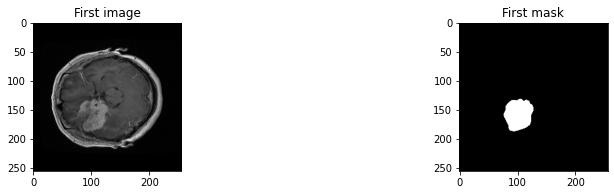

In [12]:
# Plot the first and last images
plt.figure(figsize = (14,6))
plt.subplot(221)
plt.imshow(np.squeeze(imgs[1]), cmap = "gray")
plt.title('First image')
plt.subplot(222)
plt.imshow(np.squeeze(masks[1]), cmap = "gray")
plt.title('First mask')
plt.show()

UNET Model Functions

In [4]:
# Dice coefficient, is a statistical tool which measures the similarity between two sets of data.

# Dice score coefficient 
def dsc(y_true, y_pred):
    smooth = 1.
    # masks
    y_true_fm = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_fm * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_fm) + K.sum(y_pred_f) + smooth) 
    return score


# Dice loss
def dice_loss(y_true, y_pred):
    loss = 1 - dsc(y_true, y_pred)
    return loss

# Performance metrics: Dice score coefficient, IOU, recall, sensitivity
def auc(y_true, y_pred):
    y_pred_pos = np.round(np.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    y_pos = np.round(np.clip(y_true, 0, 1)) # ground truth
    y_neg = 1 - y_pos
    tp = np.sum(y_pos * y_pred_pos)
    tn = np.sum(y_neg * y_pred_neg)
    fp = np.sum(y_neg * y_pred_pos)
    fn = np.sum(y_pos * y_pred_neg)
    tpr = (tp + K.epsilon()) / (tp + fn + K.epsilon()) #recall
    tnr = (tn + K.epsilon()) / (tn + fp + K.epsilon())
    prec = (tp + K.epsilon()) / (tp + fp + K.epsilon()) #precision
    iou = (tp + K.epsilon()) / (tp + fn + fp + K.epsilon()) #intersection over union
    dsc = (2*tp + K.epsilon()) / (2*tp + fn + fp + K.epsilon()) #dice score
    return [dsc, iou, tpr, prec]

In [5]:
# Convolutional block for UNet
def ConvBlock(in_fmaps, num_fmaps):
    
    # Inputs: feature maps for UNet, number of output feature maps
    conv1 = Conv2D(num_fmaps, (3, 3), activation='relu', padding='same')(in_fmaps)
    conv_out = Conv2D(num_fmaps, (3, 3), activation='relu', padding='same')(conv1)
    return conv_out

UNET Model


In [6]:
# The u-net is convolutional network architecture for fast and precise segmentation of images. 

# Build the model

def Network():
    
    input = Input(shape=input_size)

    conv1 = ConvBlock(input, 16)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = ConvBlock(pool1, 16)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = ConvBlock(pool2, 32)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = ConvBlock(pool3, 32)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = ConvBlock(pool4, 64)
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)

    conv6 = ConvBlock(pool5, 64)
    pool6 = MaxPooling2D(pool_size=(2, 2))(conv6)

    conv7 = ConvBlock(pool6, 128)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv6], axis=3)
    conv8 = ConvBlock(up8, 64)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8), conv5], axis=3)
    conv9 = ConvBlock(up9, 64)

    up10 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv9), conv4], axis=3)
    conv10 = ConvBlock(up10, 32)

    up11 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv10), conv3], axis=3)
    conv11 = ConvBlock(up11, 32)

    up12 = concatenate([Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv11), conv2], axis=3)
    conv12 = ConvBlock(up12, 16)

    up13 = concatenate([Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv12), conv1], axis=3)
    conv13 = ConvBlock(up13, 16)

    conv14 = Conv2D(1, (1, 1), activation='sigmoid')(conv13)

    model = Model(inputs = input, outputs = conv14)

    return model  

Training and Testing of Model

In [7]:
# sklearn-useful library for machine learning in Python
# model_selection is a package in sklearn library(process of selecting one final machine learning model from among a collection of candidate machine learning)
# train_test_split is a module(a file consisting of Python code)

train, test = train_test_split(np.arange(0,200), test_size=0.30, random_state=80)

In [8]:
# Define  the model
model = Network()


# Split into train and test sets
imgs_train, masks_train, imgs_test, masks_test = imgs[train], masks[train], imgs[test], masks[test]


# Compile the model
# compile function configures the Sequential model for training.
# Optimizers are algorithms or methods used to change the attributes of the neural network such as weights and learning rate to reduce the losses. Optimizers are used to solve optimization problems by minimizing the function.
# Crossentropy loss function when there are two or more label classes.
# We expect labels to be provided as integers.
model.compile(optimizer = Adam(learning_rate = 0.0001), loss = dice_loss, metrics = [dsc])


batchnum = 10
epochnum = 50

#now() function Return the current local date and time, which is defined under datetime module.
t = now()


#Stop training when a monitored metric has stopped improving. Assuming the goal of a training is to minimize the loss. ... fit() training loop will check at end of every epoch whether the loss is no longer decreasing, considering the min_delta and patience if applicable.
callbacks = [EarlyStopping(monitor='val_loss', patience = 15)]

print("Fit model on training data")


# Fit the model
# verbose=2 just specifies how much output to the console we want to see during each epoch of training. The verbosity levels range from 0 to 2, so we're getting the most verbose output.
history = model.fit(imgs_train, masks_train, validation_split=0.15, batch_size=batchnum, 
                    epochs=epochnum, verbose=2, callbacks=callbacks)


print(history)
print('Training time: %s' % (now() - t))

Fit model on training data
Epoch 1/50
12/12 - 41s - loss: 0.9771 - dsc: 0.0230 - val_loss: 0.9842 - val_dsc: 0.0153
Epoch 2/50
12/12 - 35s - loss: 0.9770 - dsc: 0.0231 - val_loss: 0.9841 - val_dsc: 0.0154
Epoch 3/50
12/12 - 36s - loss: 0.9769 - dsc: 0.0231 - val_loss: 0.9841 - val_dsc: 0.0154
Epoch 4/50
12/12 - 35s - loss: 0.9768 - dsc: 0.0232 - val_loss: 0.9840 - val_dsc: 0.0155
Epoch 5/50
12/12 - 34s - loss: 0.9767 - dsc: 0.0233 - val_loss: 0.9839 - val_dsc: 0.0156
Epoch 6/50
12/12 - 34s - loss: 0.9764 - dsc: 0.0237 - val_loss: 0.9837 - val_dsc: 0.0158
Epoch 7/50
12/12 - 34s - loss: 0.9761 - dsc: 0.0239 - val_loss: 0.9835 - val_dsc: 0.0161
Epoch 8/50
12/12 - 33s - loss: 0.9756 - dsc: 0.0244 - val_loss: 0.9830 - val_dsc: 0.0165
Epoch 9/50
12/12 - 34s - loss: 0.9748 - dsc: 0.0252 - val_loss: 0.9823 - val_dsc: 0.0172
Epoch 10/50
12/12 - 33s - loss: 0.9733 - dsc: 0.0267 - val_loss: 0.9811 - val_dsc: 0.0185
Epoch 11/50
12/12 - 34s - loss: 0.9704 - dsc: 0.0297 - val_loss: 0.9783 - val_dsc:

Plotting Loss and Accuracy

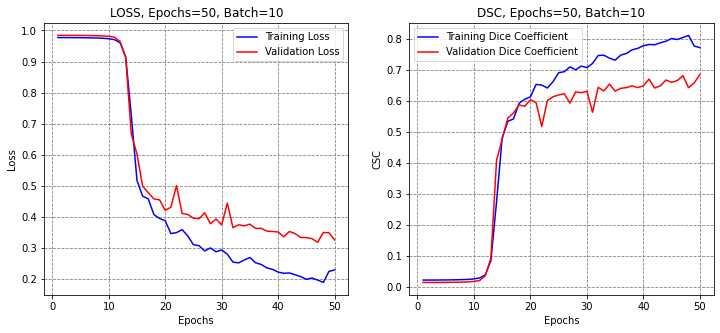

In [9]:
# Plot the loss and accuracy
train_loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['dsc'] 
val_acc = history.history['val_dsc']

epochsn = np.arange(1, len(train_loss)+1,1)
plt.figure(figsize = (12,5))
plt.subplot(121)
plt.plot(epochsn,train_loss, 'b', label='Training Loss')
plt.plot(epochsn,val_loss, 'r', label='Validation Loss')
plt.grid(color='gray', linestyle='--')
plt.legend()
plt.title('LOSS, Epochs={}, Batch={}'.format(epochnum, batchnum))
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(122)
plt.plot(epochsn, acc, 'b', label='Training Dice Coefficient')
plt.plot(epochsn, val_acc, 'r', label='Validation Dice Coefficient')
plt.grid(color='gray', linestyle='--')
plt.legend()            
plt.title('DSC, Epochs={}, Batch={}'.format(epochnum, batchnum))
plt.xlabel('Epochs')
plt.ylabel('CSC')
plt.show()


Predictions of the Model

In [10]:
# Make predictions
t = now()

# Predicting the masks for their respective images
preds = model.predict(imgs_test)
print('Testing time: %s' % (now() - t))


# Evaluate model
num_test = len(imgs_test)
# Calculate performance metrics
dsc_sc = np.zeros((num_test,1))
iou_sc = np.zeros_like(dsc_sc)
rec_sc = np.zeros_like(dsc_sc)
tn_sc = np.zeros_like(dsc_sc)
prec_sc = np.zeros_like(dsc_sc)




# Presenting the final images
num_disp = 10
j=1
plt.figure(figsize = (14,num_disp*3))
for i in range(num_disp):
    plt.subplot(num_disp,4,j)
    plt.imshow(np.squeeze(imgs_test[i]), cmap='gray')
    plt.title('Image')
    j +=1
    plt.subplot(num_disp,4,j)
    plt.imshow(np.squeeze(masks_test[i]),cmap='gray')
    plt.title('Mask')
    j +=1
    plt.subplot(num_disp,4,j)
    plt.imshow(np.squeeze(preds[i]))
    plt.title('Prediction')
    j +=1
    plt.subplot(num_disp,4,j)
plt.tight_layout()
plt.show()   





# Confusion matrix
confusion = confusion_matrix( masks_test.ravel(),preds.ravel())
accuracy = 0
if float(np.sum(confusion))!=0:
    accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
print(' Global Acc \t{0:^.3f}'.format(accuracy))


# Save outputs 
numepochs = epochsn[-1]
dice_score = np.sum(dsc_sc)/num_test
iou_score = np.sum(iou_sc)/num_test
rec_score = np.sum(rec_sc)/num_test
prec_score = np.sum(prec_sc)/num_test
globacc_score = accuracy

Save and load a Model

In [ ]:
# File path and name of the file we want to save the model to with an h5 extension.
# Will save everything about the model – the architecture, the weights, the optimizer, the state of the optimizer, the learning rate, the loss, etc.


#Checks first to see if the file exists already.
#if not,the model is saved to disk.

import os.path
if os.path.isfile('D:\DIC\DIC Brain Tumor\Model/Model.h5') is False:
    model.save('D:\DIC\DIC Brain Tumor\Model/Model.h5')

Error: Session cannot generate requests

In [ ]:
#function to load the model by pointing to the saved model on disk.

# from tensorflow.keras.models import load_model
# new_model=load_model('D:\DIC\DIC Brain Tumor\Model/Model.h5')